In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

from sklearn import preprocessing
import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

import seaborn as sns

from datetime import timedelta
from pylab import rcParams

from xgboost import plot_tree
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

## Trabajaremos con la estación MGH

Leemos los archivos por hora:

In [115]:
data_hora_12 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2012.csv')
data_hora_13 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2013.csv')
data_hora_14 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2014.csv')
data_hora_15 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2015.csv')
data_hora_16 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2016.csv')
data_hora_17 = pd.read_csv('/home/paw/DanielBustillos/datasets/dia/cont_hora2017.csv')

In [116]:
data_hora_17 = data_hora_17.append(data_hora_16, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_15, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_14, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_13, ignore_index=True)
data_hora_17 = data_hora_17.append(data_hora_12, ignore_index=True)

In [117]:
data_hora = data_hora_17

In [118]:
data_hora['dia'] = data_hora['fecha'].astype(str).str[8:10]
data_hora['mes'] =  data_hora['fecha'].astype(str).str[5:7]

In [119]:
data_hora['fecha'] = data_hora['fecha'].astype(str).str[0:10]

In [120]:
data_hora = data_hora.drop(["Unnamed: 0"],axis=1)
data_hora = data_hora.drop_duplicates()
data_hora = data_hora[1::]

In [121]:
#data_hora = data_hora.drop(["UVA","UVB"],axis=1)

In [122]:
data_hora = data_hora.dropna()

In [123]:
data_hora.id_station.unique()

array(['MER', 'TLA'], dtype=object)

In [124]:
data_hora.head()

,fecha,hora,dia,mes,id_station,UVA,UVB,PA,CO,NO,...,NOX,O3,PM2.5,PMCO,SO2,RH,TMP,WSP,WDR,PM10
9,2017-01-01,1,01,01,MER,0.0,0.0,585.0,1.3,22.0,...,69.0,3.0,46.0,27.0,5.0,63.0,14.4,0.8,205.0,73.0
26,2017-01-01,2,01,01,MER,0.0,0.0,585.0,1.3,18.0,...,62.0,1.0,73.0,32.0,6.0,67.0,13.7,0.8,144.0,105.0
43,2017-01-01,3,01,01,MER,0.0,0.0,585.0,1.2,11.0,...,52.0,2.0,74.0,29.0,5.0,66.0,13.6,0.5,164.0,103.0
61,2017-01-01,4,01,01,MER,0.0,0.0,585.0,1.4,31.0,...,70.0,2.0,84.0,30.0,5.0,66.0,13.5,0.7,183.0,114.0
80,2017-01-01,5,01,01,MER,0.0,0.0,585.0,1.5,32.0,...,70.0,1.0,100.0,36.0,5.0,70.0,12.6,1.1,162.0,136.0


## Juntamos todas las estaciones

In [16]:
data_hora = data_hora.groupby(['fecha',"dia","hora","mes"])[ 
       'PA', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH',
       'TMP', 'WSP', 'WDR', 'PM10'].mean()
data_hora.reset_index(inplace=True)


# Promedio Diario

In [126]:
data_hora.head()

,fecha,hora,dia,mes,id_station,UVA,UVB,PA,CO,NO,...,NOX,O3,PM2.5,PMCO,SO2,RH,TMP,WSP,WDR,PM10
9,2017-01-01,1,01,01,MER,0.0,0.0,585.0,1.3,22.0,...,69.0,3.0,46.0,27.0,5.0,63.0,14.4,0.8,205.0,73.0
26,2017-01-01,2,01,01,MER,0.0,0.0,585.0,1.3,18.0,...,62.0,1.0,73.0,32.0,6.0,67.0,13.7,0.8,144.0,105.0
43,2017-01-01,3,01,01,MER,0.0,0.0,585.0,1.2,11.0,...,52.0,2.0,74.0,29.0,5.0,66.0,13.6,0.5,164.0,103.0
61,2017-01-01,4,01,01,MER,0.0,0.0,585.0,1.4,31.0,...,70.0,2.0,84.0,30.0,5.0,66.0,13.5,0.7,183.0,114.0
80,2017-01-01,5,01,01,MER,0.0,0.0,585.0,1.5,32.0,...,70.0,1.0,100.0,36.0,5.0,70.0,12.6,1.1,162.0,136.0


In [127]:
data_mean = data_hora.groupby(['fecha'])[ 'PA', 'CO',
       'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP',
       'WDR', 'PM10'].mean()
data_mean.reset_index(inplace=True)

In [128]:
data_min = data_hora.groupby(['fecha'])['PA', 'CO',
       'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP',
       'WDR', 'PM10'].min()
data_min.reset_index(inplace=True)

In [129]:
data_max = data_hora.groupby(['fecha'])[ 'PA', 'CO',
       'NO', 'NO2', 'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP',
       'WDR', 'PM10'].max()
data_max.reset_index(inplace=True)

In [130]:
data_day = pd.merge(data_min, data_max, on=["fecha"])
data_day = pd.merge(data_day, data_mean, on=["fecha"])

In [131]:
data_day['fecha'] =  pd.to_datetime(data_day['fecha'], format='%Y-%m-%d %H:%M')

In [132]:
data_day.head()

,fecha,PA_x,CO_x,NO_x,NO2_x,NOX_x,O3_x,PM2.5_x,PMCO_x,SO2_x,...,NOX,O3,PM2.5,PMCO,SO2,RH,TMP,WSP,WDR,PM10
0,2012-01-01,586.0,0.3,3.0,10.0,15.0,1.0,5.0,7.0,2.0,...,65.958333,18.833333,64.291667,32.291667,5.416667,53.208333,13.675000,2.912500,198.083333,96.666667
1,2012-01-02,590.0,0.1,0.0,5.0,5.0,3.0,2.0,2.0,2.0,...,36.608696,12.782609,7.260870,14.434783,2.130435,61.086957,11.504348,3.965217,323.434783,21.869565
2,2012-01-03,587.0,0.3,3.0,19.0,22.0,1.0,8.0,8.0,2.0,...,65.950000,15.200000,21.050000,28.750000,7.200000,53.800000,11.470000,2.200000,271.200000,49.800000
3,2012-01-04,585.0,0.4,7.0,28.0,43.0,1.0,17.0,17.0,4.0,...,94.750000,17.208333,35.166667,35.875000,16.166667,52.250000,12.808333,1.833333,138.000000,70.875000
4,2012-01-05,584.0,0.4,10.0,33.0,50.0,1.0,15.0,20.0,3.0,...,92.458333,16.916667,26.625000,34.000000,14.416667,43.416667,13.683333,2.012500,141.458333,60.541667


In [134]:
data_day.columns

Index(['fecha', 'PA_x', 'CO_x', 'NO_x', 'NO2_x', 'NOX_x', 'O3_x', 'PM2.5_x',
       'PMCO_x', 'SO2_x', 'RH_x', 'TMP_x', 'WSP_x', 'WDR_x', 'PM10_x', 'PA_y',
       'CO_y', 'NO_y', 'NO2_y', 'NOX_y', 'O3_y', 'PM2.5_y', 'PMCO_y', 'SO2_y',
       'RH_y', 'TMP_y', 'WSP_y', 'WDR_y', 'PM10_y', 'PA', 'CO', 'NO', 'NO2',
       'NOX', 'O3', 'PM2.5', 'PMCO', 'SO2', 'RH', 'TMP', 'WSP', 'WDR', 'PM10'],
      dtype='object')

## Añadimos Precipitación que solo esta en días:

## Precipitación

In [135]:
prec_2017 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2017PPH.xls')
prec_2016 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2016PPH.xls')
prec_2015 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2015PPH.xls')
prec_2014 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2014PPH.xls')
prec_2013 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2013PPH.xls')
prec_2012 = pd.read_excel('/home/paw/DanielBustillos/datasets/precipitacion/2012PPH.xls')

In [136]:
prec_2017 = prec_2017.append(prec_2016, ignore_index=True)
prec_2017 = prec_2017.append(prec_2015, ignore_index=True)
prec_2017 = prec_2017.append(prec_2014, ignore_index=True)
prec_2017 = prec_2017.append(prec_2013, ignore_index=True)
prec_2017 = prec_2017.append(prec_2012, ignore_index=True)

In [137]:
prec = prec_2017

Los valores vacíos vienen como -99, vamos a eliminarlos:

In [138]:
prec = prec.where(prec.LOM != -99.00)

In [139]:
prec = prec.dropna()

Renombramos algunas columnas:

In [140]:
prec = prec.rename(columns={'FECHA': 'fecha'})

Transponemos el df:

In [141]:
prec = pd.melt(prec, id_vars=["fecha"], 
                   var_name="id_station",value_name="Precip")

In [142]:
prec['fecha'] =  pd.to_datetime(prec['fecha'], format='%Y-%m-%d %H:%M')

In [143]:
prec = prec[prec.id_station=="TLA"]

## Lo unimos con el archivo ya generado:

In [145]:
data_day_avg = pd.merge(data_day, prec, on=["fecha"],  how='left')

In [146]:
#data_day_avg["fecha"] =  pd.to_datetime(data_day["fecha"], format='%Y-%m-%d %H:%M')

In [147]:
data_day_avg = data_day_avg.fillna(0)

In [148]:
data_day_avg["dia"] = pd.DatetimeIndex(data_day_avg['fecha']).day
data_day_avg["mes"] = pd.DatetimeIndex(data_day_avg['fecha']).month

In [149]:
data_day_avg = data_day_avg.drop(["id_station","fecha"],axis=1)

In [150]:
data_day_avg.head()

,PA_x,CO_x,NO_x,NO2_x,NOX_x,O3_x,PM2.5_x,PMCO_x,SO2_x,RH_x,...,PMCO,SO2,RH,TMP,WSP,WDR,PM10,Precip,dia,mes
0,586.0,0.3,3.0,10.0,15.0,1.0,5.0,7.0,2.0,21.0,...,32.291667,5.416667,53.208333,13.675000,2.912500,198.083333,96.666667,0.0,1,1
1,590.0,0.1,0.0,5.0,5.0,3.0,2.0,2.0,2.0,53.0,...,14.434783,2.130435,61.086957,11.504348,3.965217,323.434783,21.869565,0.0,2,1
2,587.0,0.3,3.0,19.0,22.0,1.0,8.0,8.0,2.0,35.0,...,28.750000,7.200000,53.800000,11.470000,2.200000,271.200000,49.800000,0.0,3,1
3,585.0,0.4,7.0,28.0,43.0,1.0,17.0,17.0,4.0,27.0,...,35.875000,16.166667,52.250000,12.808333,1.833333,138.000000,70.875000,0.0,4,1
4,584.0,0.4,10.0,33.0,50.0,1.0,15.0,20.0,3.0,27.0,...,34.000000,14.416667,43.416667,13.683333,2.012500,141.458333,60.541667,0.0,5,1


### Limpiemos los outliers

In [178]:
data_hour_merge_24 = data_day_avg

In [179]:
data_hour_merge_24["PM10_1_fcst"] = data_hour_merge_24.O3_y.shift(1)
data_hour_merge_24["PM10_1_a"] = data_hour_merge_24.PM10.shift(-1)
data_hour_merge_24["PM10_2_a"] = data_hour_merge_24.PM10.shift(-2)
data_hour_merge_24["PM10_3_a"] = data_hour_merge_24.PM10.shift(-3)
data_hour_merge_24["PM10_4_a"] = data_hour_merge_24.PM10.shift(-4)

data_hour_merge_24["PM10_2_y"] = data_hour_merge_24.PM10_y.shift(-2)
data_hour_merge_24["PM10_3_y"] = data_hour_merge_24.PM10_y.shift(-3)
data_hour_merge_24["PM10_4_y"] = data_hour_merge_24.PM10_y.shift(-4)


data_hour_merge_24["PM10_24"] = data_hour_merge_24.PM10_y.shift(-1)
data_hour_merge_24["PM10_24_x"] = data_hour_merge_24.PM10_x.shift(1)
data_hour_merge_24["temp_24"] = data_hour_merge_24.TMP.shift(-1)
data_hour_merge_24["pre_24"] = data_hour_merge_24.PA.shift(-1)
data_hour_merge_24["RH_24"] = data_hour_merge_24.RH_y.shift(-1)
data_hour_merge_24["RH_24_2"] = data_hour_merge_24.RH_y.shift(-2)

data_hour_merge_24["RH_24"] = data_hour_merge_24.RH_y.shift(-1)
data_hour_merge_24["RH_24_2"] = data_hour_merge_24.RH_y.shift(-2)

data_hour_merge_24["UVB_x_1"] = data_hour_merge_24.UVB_x.shift(-1)
data_hour_merge_24["UVB_x_2"] = data_hour_merge_24.UVB_x.shift(-2)
data_hour_merge_24["UVB_y_1"] = data_hour_merge_24.UVB_y.shift(-1)
data_hour_merge_24["UVB_y_2"] = data_hour_merge_24.UVB_y.shift(-2)

#data_MGH_18 = data_MGH_18.iloc[:,:-6]

AttributeError: 'DataFrame' object has no attribute 'UVB_x'

In [180]:
data_hour_merge_24 = data_hour_merge_24.dropna(how='any')

In [154]:
data_hour_merge_24['dia'] = data_hour_merge_24['dia'].astype(str).astype(float)
data_hour_merge_24['mes'] = data_hour_merge_24['mes'].astype(str).astype(float)

/home/paw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/paw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [155]:
corr = data_hour_merge_24.corr();

In [156]:
corr["PM10_predict"].sort_values(ascending=True);

In [157]:
columns_df = data_hour_merge_24.columns

In [158]:
columns_df.tolist();

### Normalizamos el DS

In [159]:
from sklearn import preprocessing

x = data_hour_merge_24.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_hour_merge_24 = pd.DataFrame(x_scaled)

In [160]:
data_hour_merge_24.columns = columns_df

In [161]:
data_hour_merge_24.head()

,PA_x,CO_x,NO_x,NO2_x,NOX_x,O3_x,PM2.5_x,PMCO_x,SO2_x,RH_x,...,PMCO_1_x,PM10_24,WDR_1,temp_24,RH_24_1,RH_1_y,RH_1_x,TMP_1,TMP_x_1,TMP_y_1
0,1.000000,0.1,0.00,0.046512,0.031746,0.088235,0.022222,0.025,0.035714,0.649351,...,0.175,0.111298,0.738922,0.204276,0.549551,0.626506,0.415584,0.204276,0.347594,0.256757
1,0.800000,0.3,0.06,0.372093,0.301587,0.029412,0.155556,0.175,0.035714,0.415584,...,0.400,0.153457,0.261962,0.284367,0.529198,0.783133,0.311688,0.284367,0.272727,0.423423
2,0.666667,0.4,0.14,0.581395,0.634921,0.029412,0.355556,0.400,0.071429,0.311688,...,0.475,0.107926,0.274346,0.336730,0.413211,0.518072,0.311688,0.336730,0.417112,0.400901
3,0.600000,0.4,0.20,0.697674,0.746032,0.029412,0.311111,0.475,0.053571,0.311688,...,0.400,0.397976,0.304185,0.342216,0.478864,0.759036,0.233766,0.342216,0.347594,0.450450
4,0.533333,0.5,0.08,0.418605,0.444444,0.029412,0.377778,0.400,0.053571,0.233766,...,0.725,0.261383,0.364760,0.382112,0.381479,0.554217,0.181818,0.382112,0.395722,0.459459


## Visualizaciones    <a class="anchor" id="viz-bullet"></a>


### Creamos los conjuntos Test y Train

In [162]:
X = data_hour_merge_24.loc[:, data_hour_merge_24.columns != 'PM10_predict']
y =  data_hour_merge_24.loc[:, data_hour_merge_24.columns == 'PM10_predict']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=123)

## Linear

In [163]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create linear regression object
regr = LinearRegression()

In [164]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [165]:
# Make predictions using the testing set
lin_pred = regr.predict(X_test)

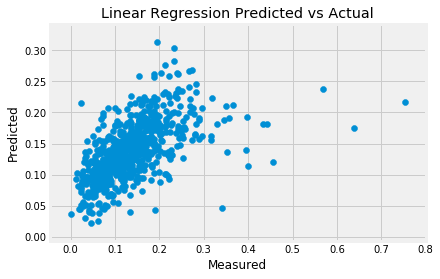

In [166]:
plt.scatter(y_test, lin_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Linear Regression Predicted vs Actual')
plt.show()

In [167]:
regr.score(X_test, y_test)

0.32597035888197134

## Neural Network Regression

In [168]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create MLPRegressor object
mlp = MLPRegressor()# alpha=900.001, max_iter=100000, epsilon=1 ,tol=.0001)
# Train the model using the training sets
mlp.fit(X_train, y_train)

/home/paw/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

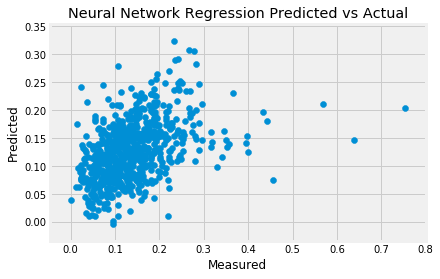

In [169]:
# Score the model
neural_network_regression_score = mlp.score(X_test, y_test)
neural_network_regression_score
# Make predictions using the testing set
nnr_pred = mlp.predict(X_test)
# The mean squared error

plt.scatter(y_test, nnr_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Neural Network Regression Predicted vs Actual')
plt.show()

In [170]:
xgb_score = mlp.score(X_test, y_test)
xgb_score

0.11780939534191248

# XGBoost ADA

In [171]:
regr_2 = AdaBoostRegressor(XGBRegressor(learning_rate = .0015, n_estimators=3000, max_depth=10),n_estimators=100)
regr_2.fit(X_train, y_train)

NameError: name 'XGBRegressor' is not defined

In [172]:
ADAXGB_pred = regr_2.predict(X_test)

NameError: name 'regr_2' is not defined

In [173]:
plt.scatter(y_test, ADAXGB_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

NameError: name 'ADAXGB_pred' is not defined

In [174]:
xgb_score = regr_2.score(X_test, y_test)
xgb_score

NameError: name 'regr_2' is not defined

## XGBOOST

In [175]:
from xgboost.sklearn import XGBRegressor

#Fitting XGB regressor 
xboost = XGBRegressor(learning_rate = .0015, n_estimators=3000, max_depth=10)

In [176]:
xboost.fit(X_train, y_train)
xgb_score = xboost.score(X_test, y_test)

In [177]:
#Predict 
xboost_pred = xboost.predict(X_test)

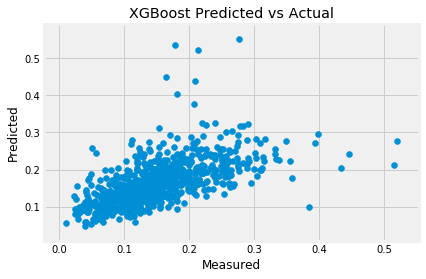

In [217]:
plt.scatter(y_test, xboost_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [218]:
xgb_score = xboost.score(X_test, y_test)
xgb_score

0.2656089107401518

## Decission Tree

In [219]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=10,max_depth=3000)

In [220]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3000, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best')

In [221]:
xboost_pred = regressor.predict(X_test)

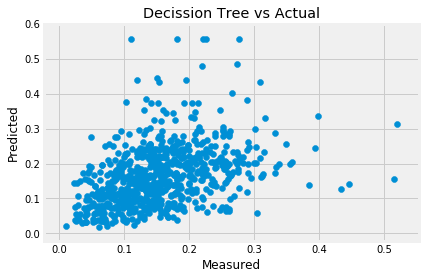

In [222]:
plt.scatter(y_test, xboost_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Decission Tree vs Actual')
plt.show()

In [228]:
regressor.score(X_test, y_test)

-0.38216940119945253

# ada

In [229]:
regr_2 = AdaBoostRegressor(LinearRegression(),n_estimators=3000)
regr_2.fit(X_train, y_train)

/home/paw/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         learning_rate=1.0, loss='linear', n_estimators=3000,
         random_state=None)

In [230]:
regr_2.score(X_test, y_test)

-0.14812866449448792

In [231]:
y_2 = regr_2.predict(X_test)

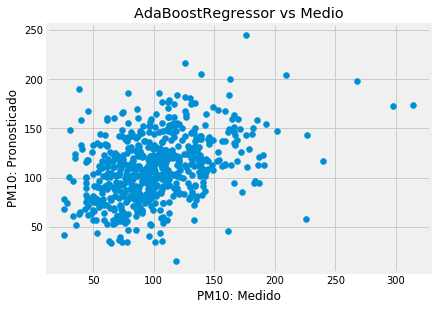

In [232]:
plt.scatter(y_test, y_2)
plt.tight_layout(1.3)
plt.xlabel('PM10: Medido')
plt.ylabel('PM10: Pronosticado')
plt.title('AdaBoostRegressor vs Medio')
plt.show()

In [233]:
rmse = np.sqrt(mean_squared_error(y_test, regr_2.predict(X_test)))
print("RMSE: %f" % (rmse))

RMSE: 40.640044


# Gracficamos:

In [234]:
y_1 = regr_2.predict(X_test)


In [235]:
X, y = data_hour_merge_24.iloc[:,:-1],data_hour_merge_24.iloc[:,-1]

In [236]:
preds = y_1.tolist()

In [237]:
yi = y_test.tolist()

AttributeError: 'DataFrame' object has no attribute 'tolist'

NameError: name 'yi' is not defined

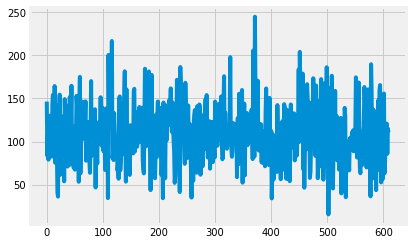

In [238]:
>>> plt.plot(preds ,label='PM10 Pronosticado')
>>> plt.plot(yi,label='PM10 Medido')
>>> plt.xlabel("Febrero 2018")
>>> plt.ylabel("PM10")
plt.tight_layout(1.3)
plt.title('Comparación de Modelo')
>>> plt.xlim(31, 60)
plt.legend()

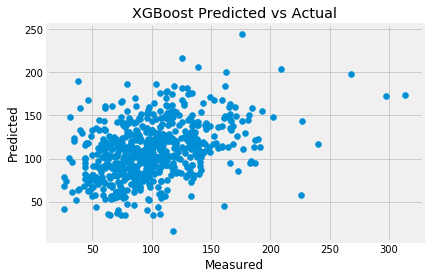

In [239]:
plt.scatter(y_test, y_2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

In [71]:
rmse = np.sqrt(mean_squared_error(y_test, y_2))
print("RMSE: %f" % (rmse))

RMSE: 10.936075


## Random forest

In [223]:
>>> from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

>>> from sklearn.datasets import make_regression

In [224]:
regr = RandomForestRegressor(max_depth=35,n_estimators=500)
regr_fit = regr.fit(X_train, y_train)

/home/paw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [225]:
y_1 = regr.predict(X_test)

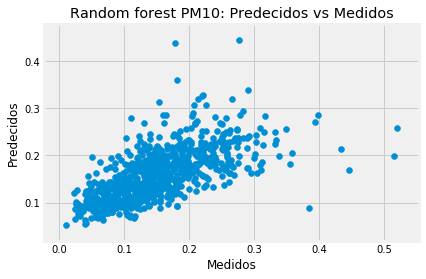

In [226]:
plt.scatter(y_test, y_1)
plt.xlabel('Medidos')
plt.ylabel('Predecidos')
plt.title('Random forest PM10: Predecidos vs Medidos')
plt.show()

In [227]:
regr.score(X_test, y_test)

0.39539609560752287

In [306]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(regr.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [307]:
importances[importances.importance > .01]

,importance
feature,
PM10_y,0.441
PM10_2_y,0.214
PM10_1_a,0.150
PM10_3_y,0.013


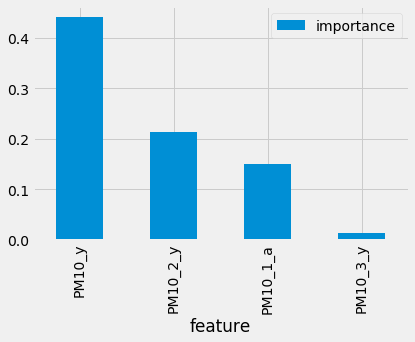

In [308]:
importances[importances.importance > .01].plot.bar()
